# Прогнозирование заказов такси

## Введение

Закзачик: Компания «Чётенькое такси»

Компании нужен прогноз заказов на следующий час, чтобы привлекать больше водителей в часы пиковой нагрузки. Для прогнозириования компания предоставила исторические данные о заказах такси в аэропортах.

### Цель проекта

Целью проекта является прогонозирование количества заказов такси в аэропортах на следующий час.

### Основные этапы

В проекте мы выполнили следующие этапы:
- загрузили и проанализировали предоставленные данные;
- подготовили данные для пронозирования;
- обучили две модели и сравнили их качество;
- проверили данные на тестовой выборке.

### Выводы

## Подготовка кода

### Загрузка библиотек

In [1]:
import pandas as pd
from os import path

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from sklearn.metrics import (mean_absolute_error, r2_score)

In [4]:
import numpy as np 

### Функции

#### exponential_smoothing

In [5]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

#### plotMovingAverage

In [6]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", lw=2, label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", alpha=.25, label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--", alpha=.25)

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=5)

    plt.plot(series[window:], alpha=.5, lw=.5, label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

#### plotExpSmoothing

In [7]:
def plotExpSmoothing(
    series, alpha, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        alpha - smoothing parameter
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    exp_smoothing = pd.DataFrame(exponential_smoothing(series.num_orders, alpha), 
                                 index=series.index, columns=series.columns)

    plt.figure(figsize=(15, 5))
    plt.title("Exponential Smoothing\n alpha = {}".format(alpha))
    plt.plot(exp_smoothing, "g", lw=2, label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series, exp_smoothing)
        deviation = np.std(series - exp_smoothing)
        lower_bond = exp_smoothing - (mae + scale * deviation)
        upper_bond = exp_smoothing + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", alpha=.25, label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--", alpha=.25)

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=5)

    plt.plot(series, alpha=.5, lw=.5, label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

### Инициализация

## Загрузка и анализ данных

In [8]:
remote_path = 'https://code.s3.yandex.net/datasets/taxi.csv'
local_path = path.join('.', 'data', 'taxi.csv')

if path.isfile(local_path):
    data = pd.read_csv(local_path, index_col=0, parse_dates=[0])
else:
    data = pd.read_csv(remote_path, index_col=0, parse_dates=[0])
    if path.exists(path.dirname(local_path)):
        data.to_csv(local_path)
        
data.shape

(26496, 1)

Загрузили 26496 строк данных с одним признаком.

### Анализ данных

#### Обзорный анализ

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В данных видим количество заказов `num_orders`, целочисленное, без пропусков. 

Диапазон времени от 0 часов 0 минут 1 марта 2018 до 23:50 31 августа 2018 года. Имеем данные за шесть месяцев.

In [10]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


В первых строчках видим 10-минутные интервалы между записями.

Проверим, что индекс монотонно возрастает.

In [11]:
data.index.is_monotonic_increasing

True

Проверим, что интервалы одинаковые и равны 10 минутам.

In [12]:
dt = data.reset_index().drop("num_orders", axis=1)
(dt["datetime"] - dt["datetime"].shift()).describe()

count              26495
mean     0 days 00:10:00
std      0 days 00:00:00
min      0 days 00:10:00
25%      0 days 00:10:00
50%      0 days 00:10:00
75%      0 days 00:10:00
max      0 days 00:10:00
Name: datetime, dtype: object

In [13]:
del(dt)

Инервалы одинаковые и равны 10 минутам.

Изучим распределение количества заказов.

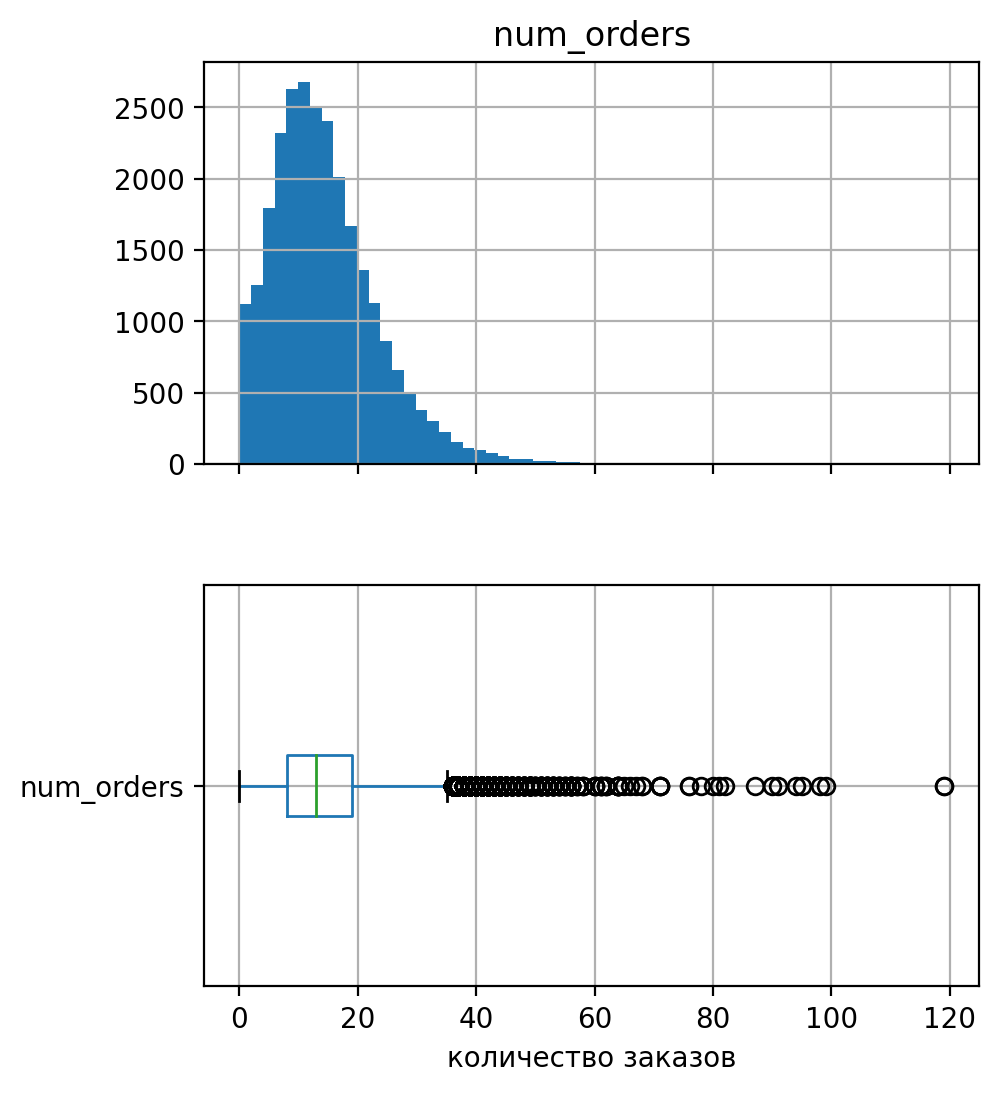

In [14]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(5, 6), sharex=True)
data.hist(bins=60, ax=ax1)
data.boxplot(ax=ax2, vert=False)
ax2.set_xlabel("количество заказов")
plt.show()

In [15]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Распределение количества заказов близко к нормальному, смещено влево. 

В половине случаев количество заказов за 10 минут находится в интервале 8–19. Однако есть и вылеты с количеством заказов больше 35. Действительно видим пиковые периоды, когда количество заказов существенно выше среднего.

#### Анализ временного ряда

Поскольку перед нами стоит задача спрогнозировать количество заказов в следующий час, выполним ресемплирование данных по 1 часу.

In [16]:
data = data.resample("1H").sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


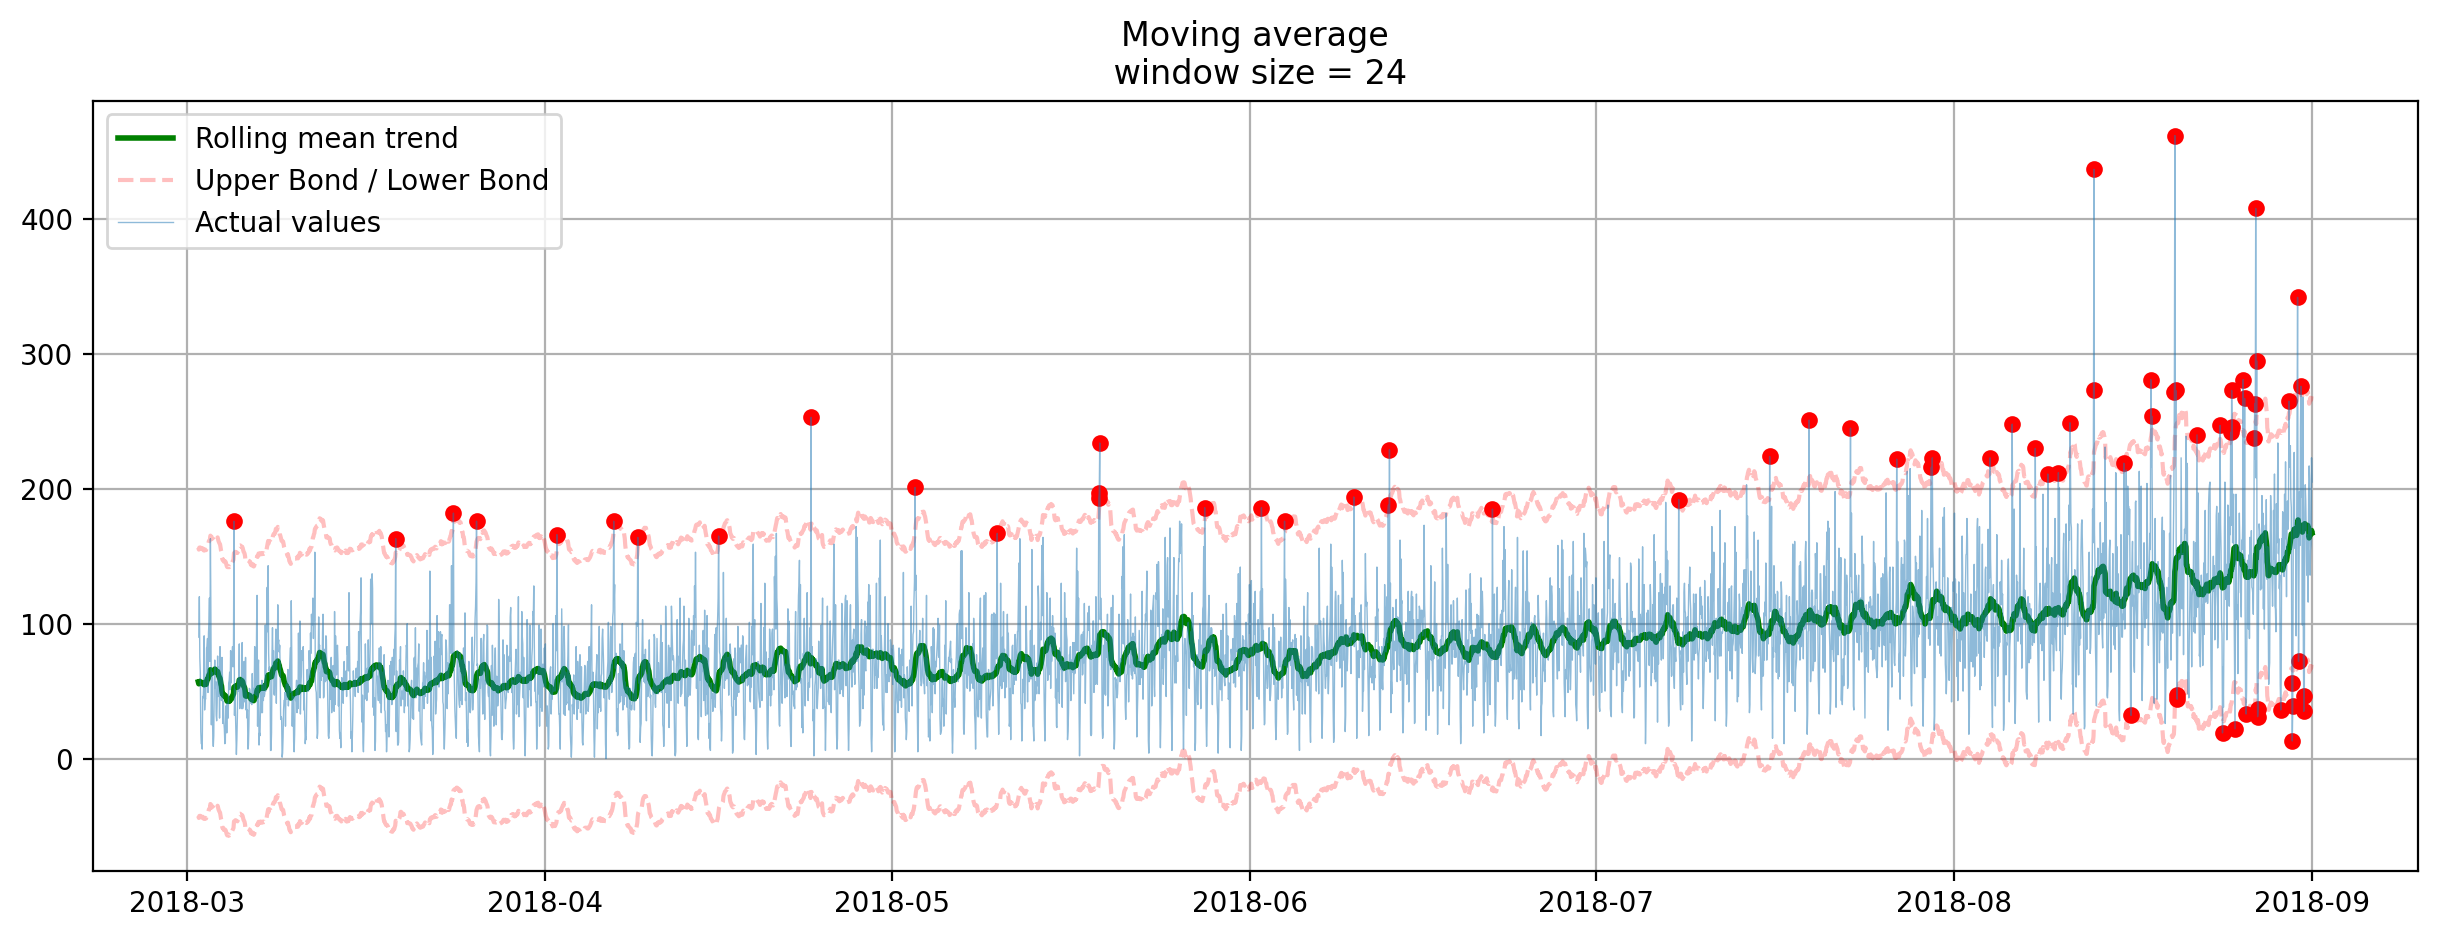

In [17]:
plotMovingAverage(
    data, 24, plot_intervals=True, plot_anomalies=True
)  # daily smoothing

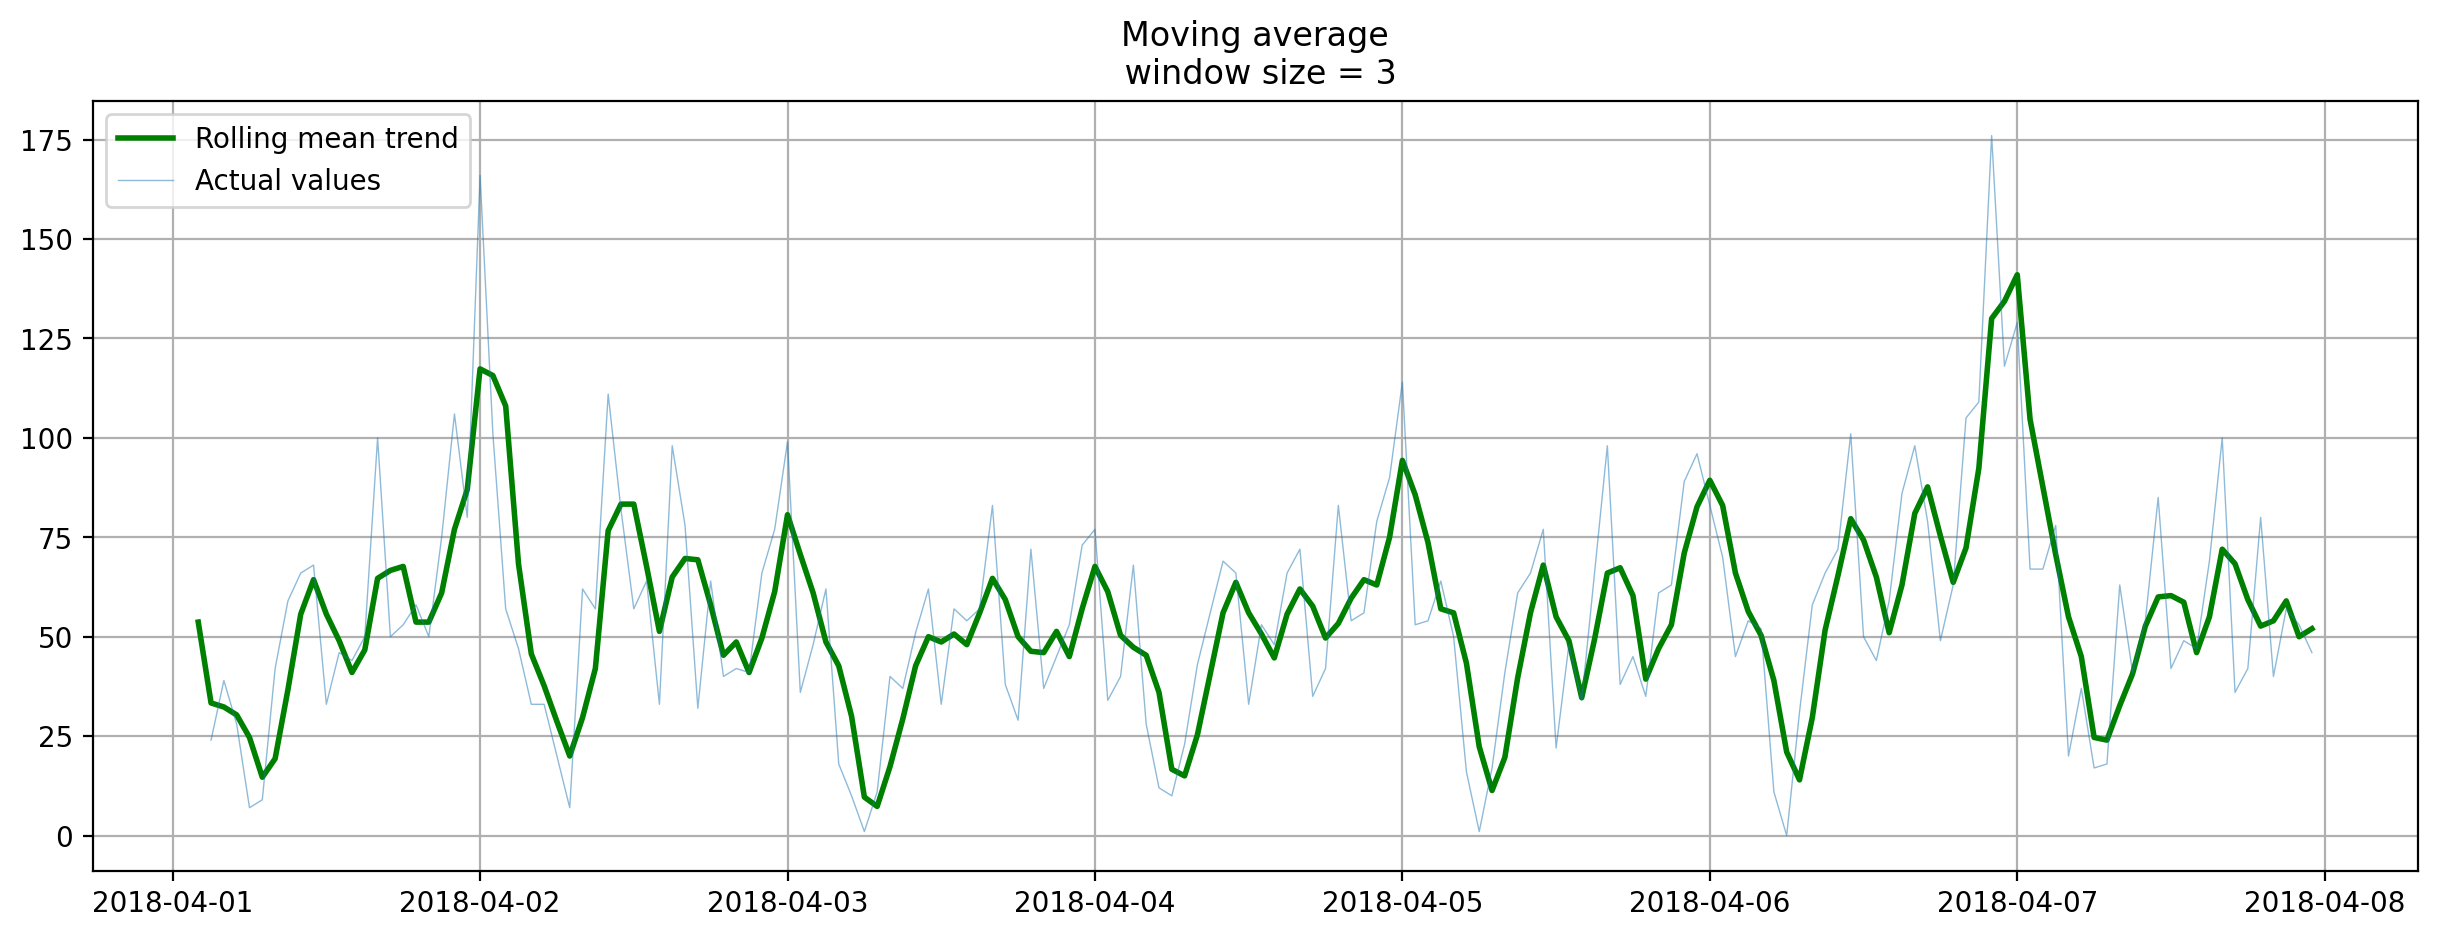

In [18]:
plotMovingAverage(
    data["2018-04-01":"2018-04-07"], 3, plot_intervals=False, plot_anomalies=False
)  # daily smoothing

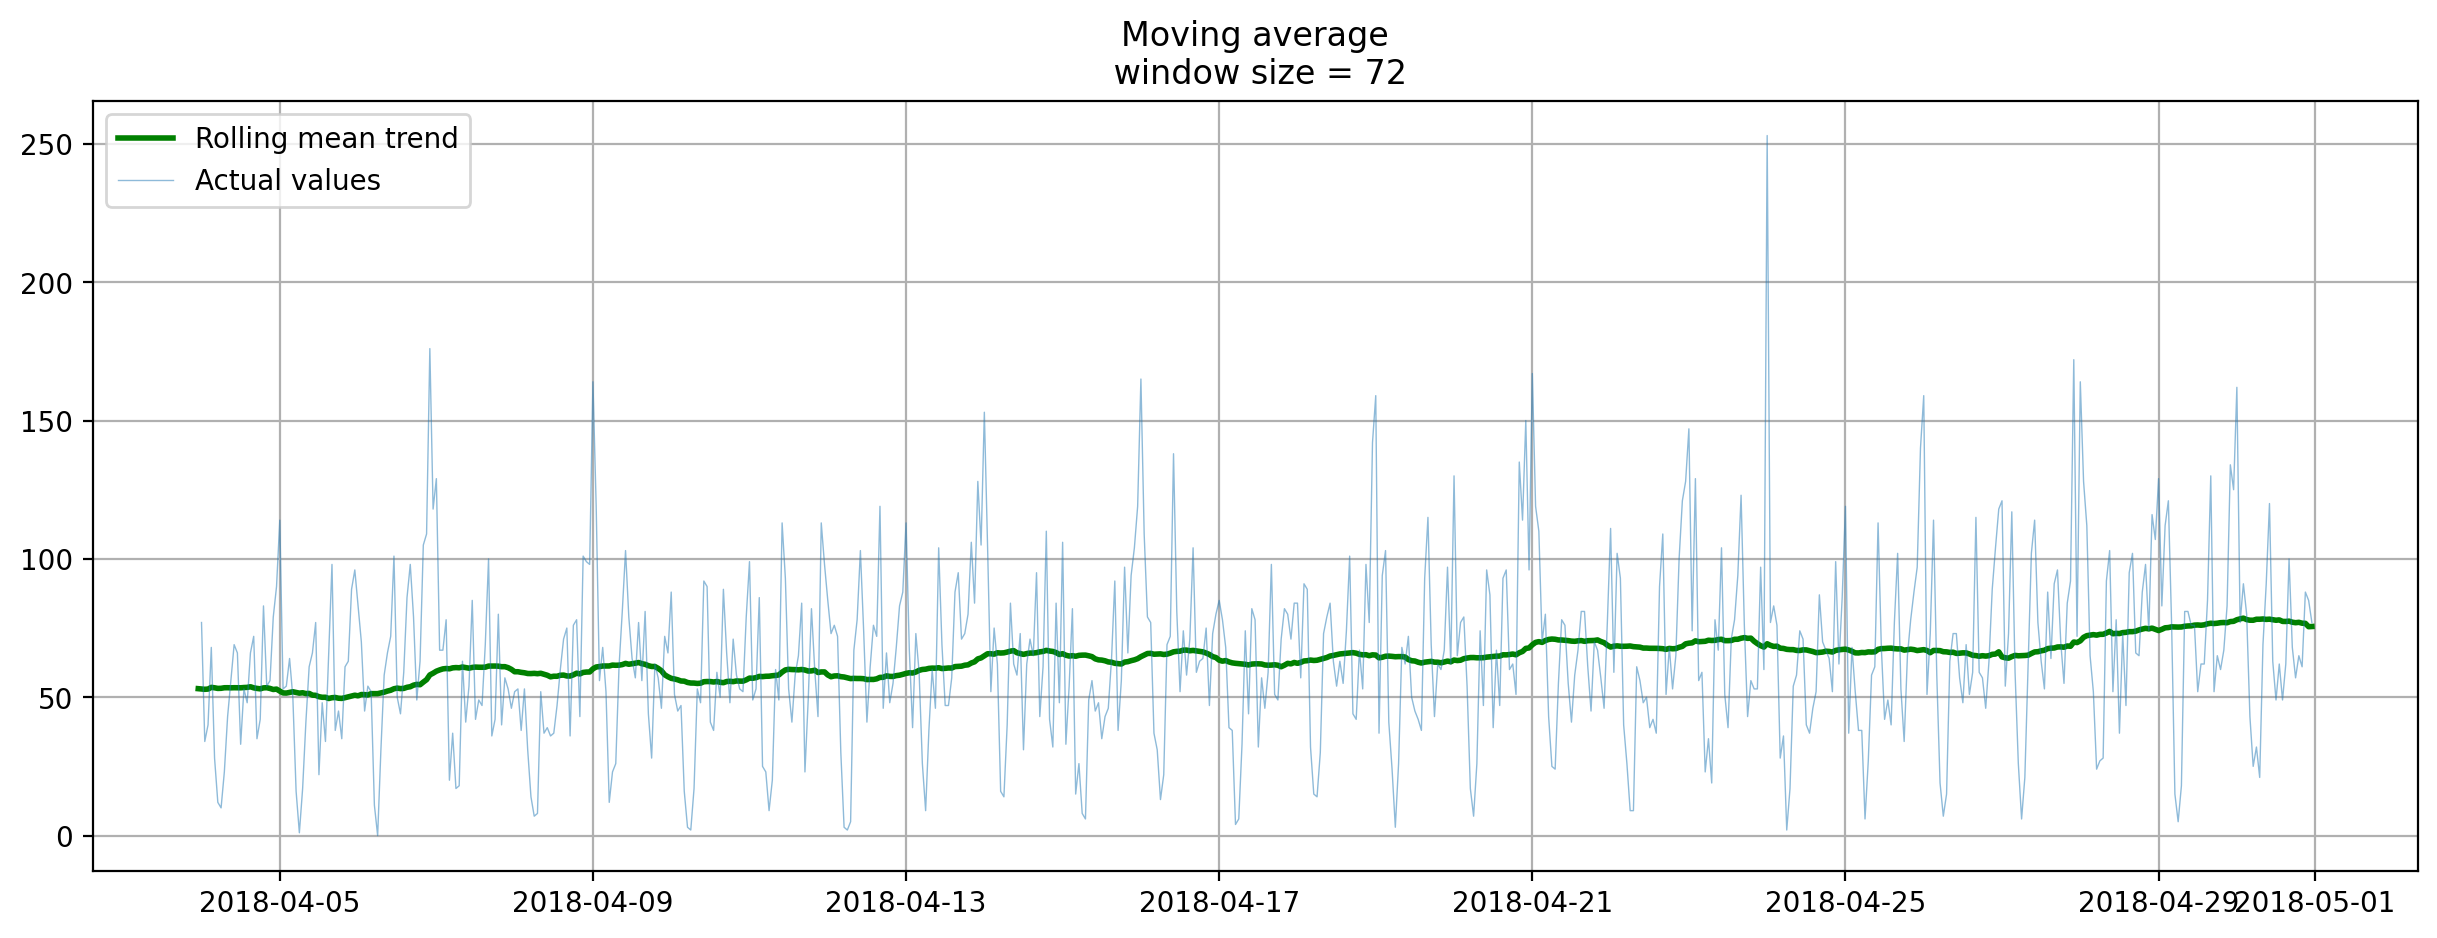

In [19]:
plotMovingAverage(
    data["2018-04-01":"2018-04-30"], 24*3, plot_intervals=False, plot_anomalies=False
)  # daily smoothing

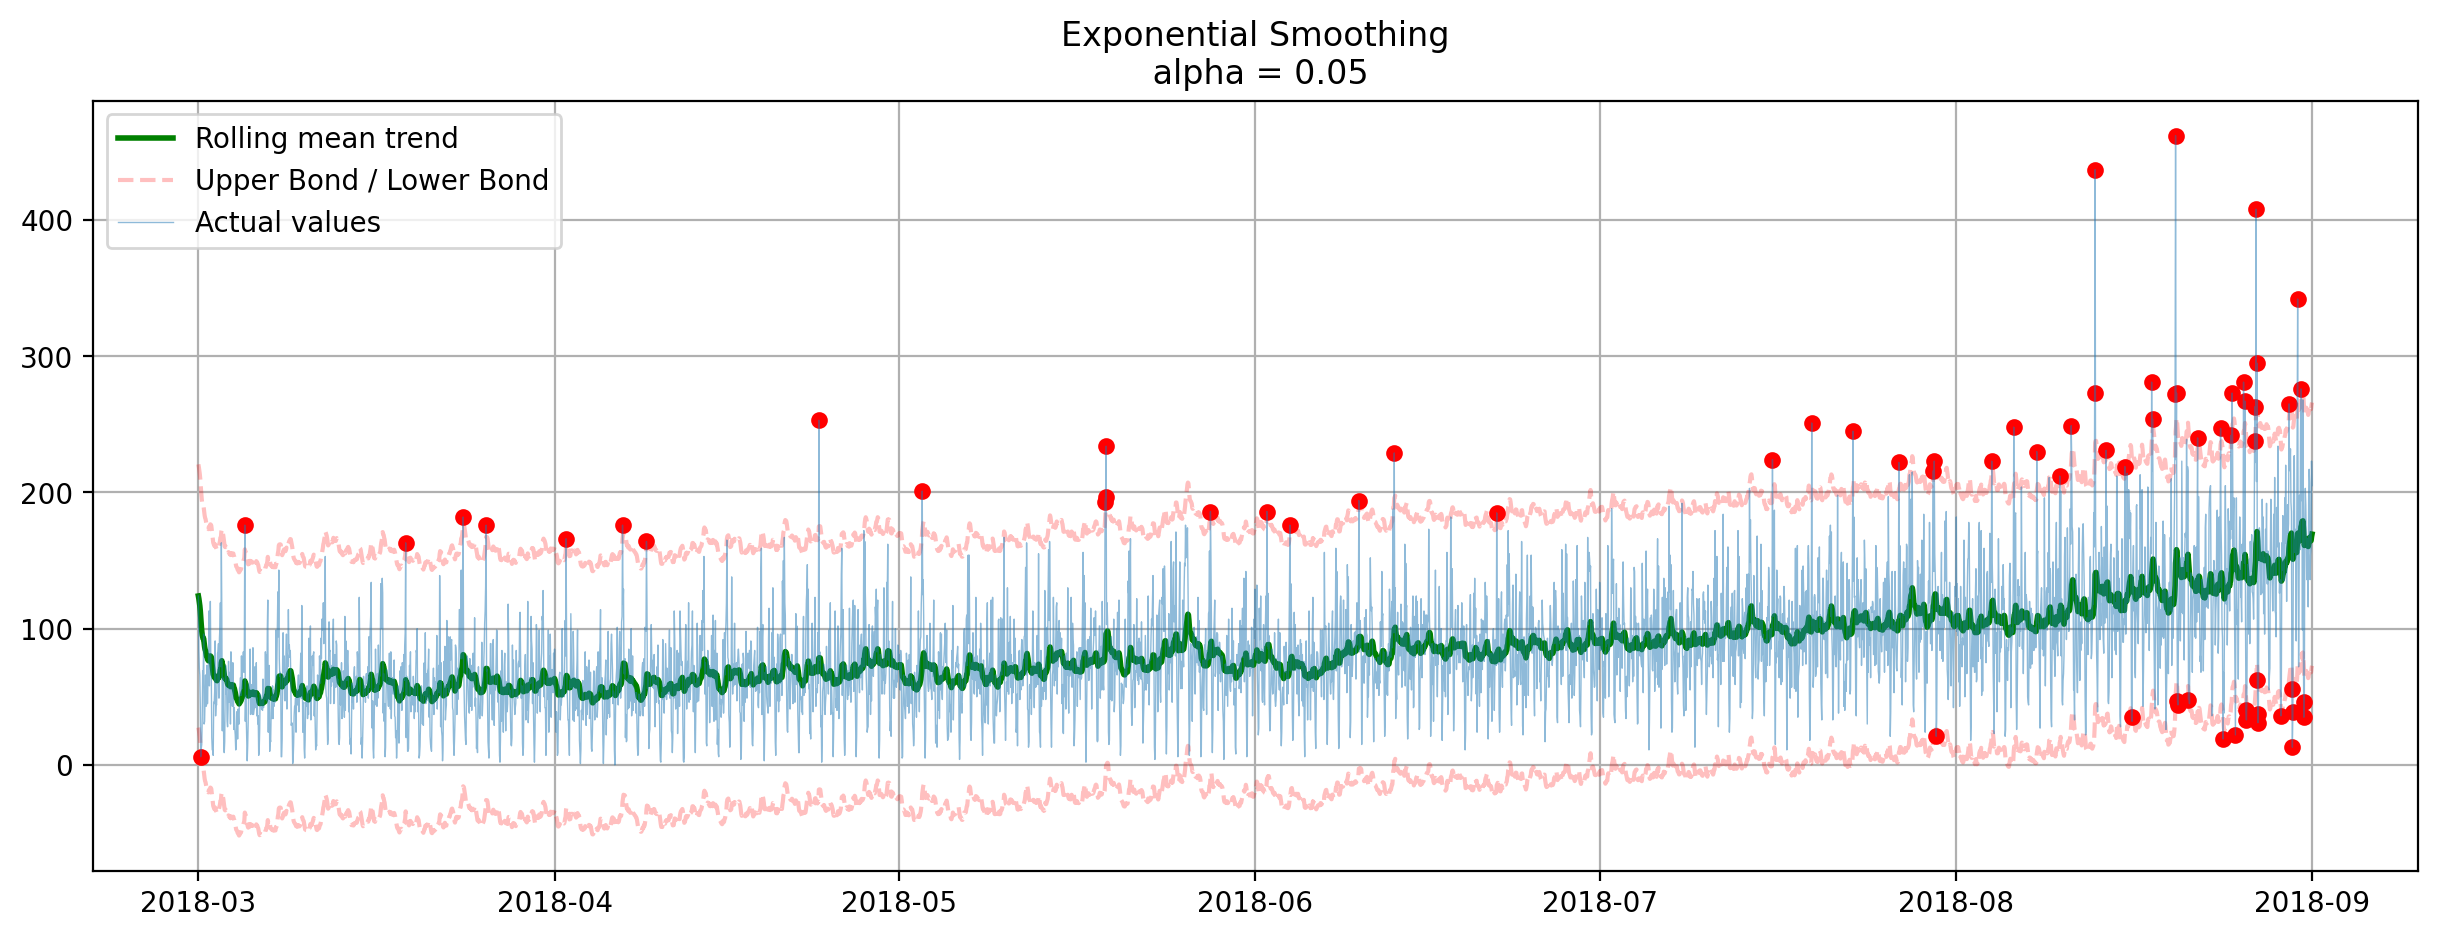

In [20]:
plotExpSmoothing(
    data, .05, plot_intervals=True, plot_anomalies=True
)

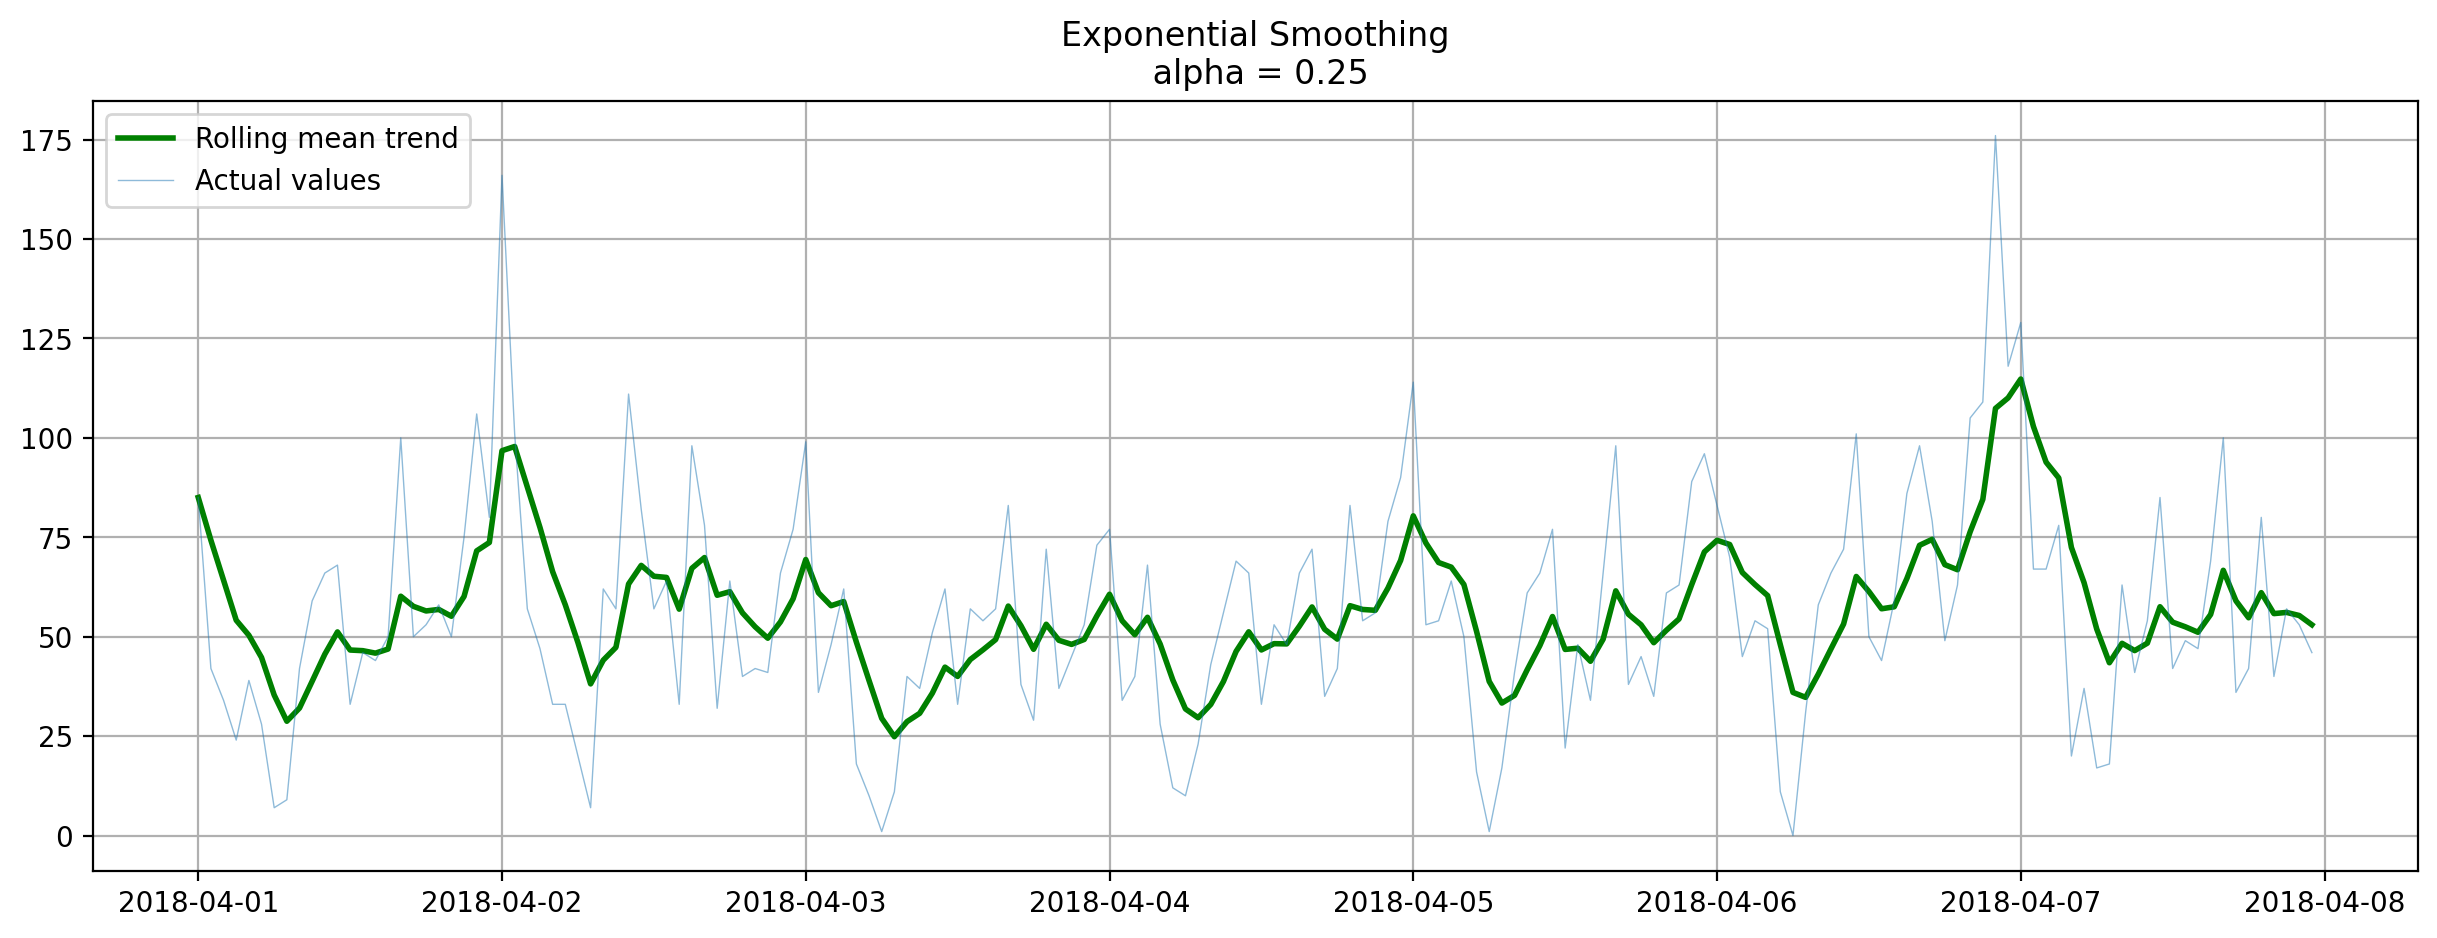

In [21]:
plotExpSmoothing(
    data["2018-04-01":"2018-04-07"], .25, plot_intervals=False, plot_anomalies=False
)

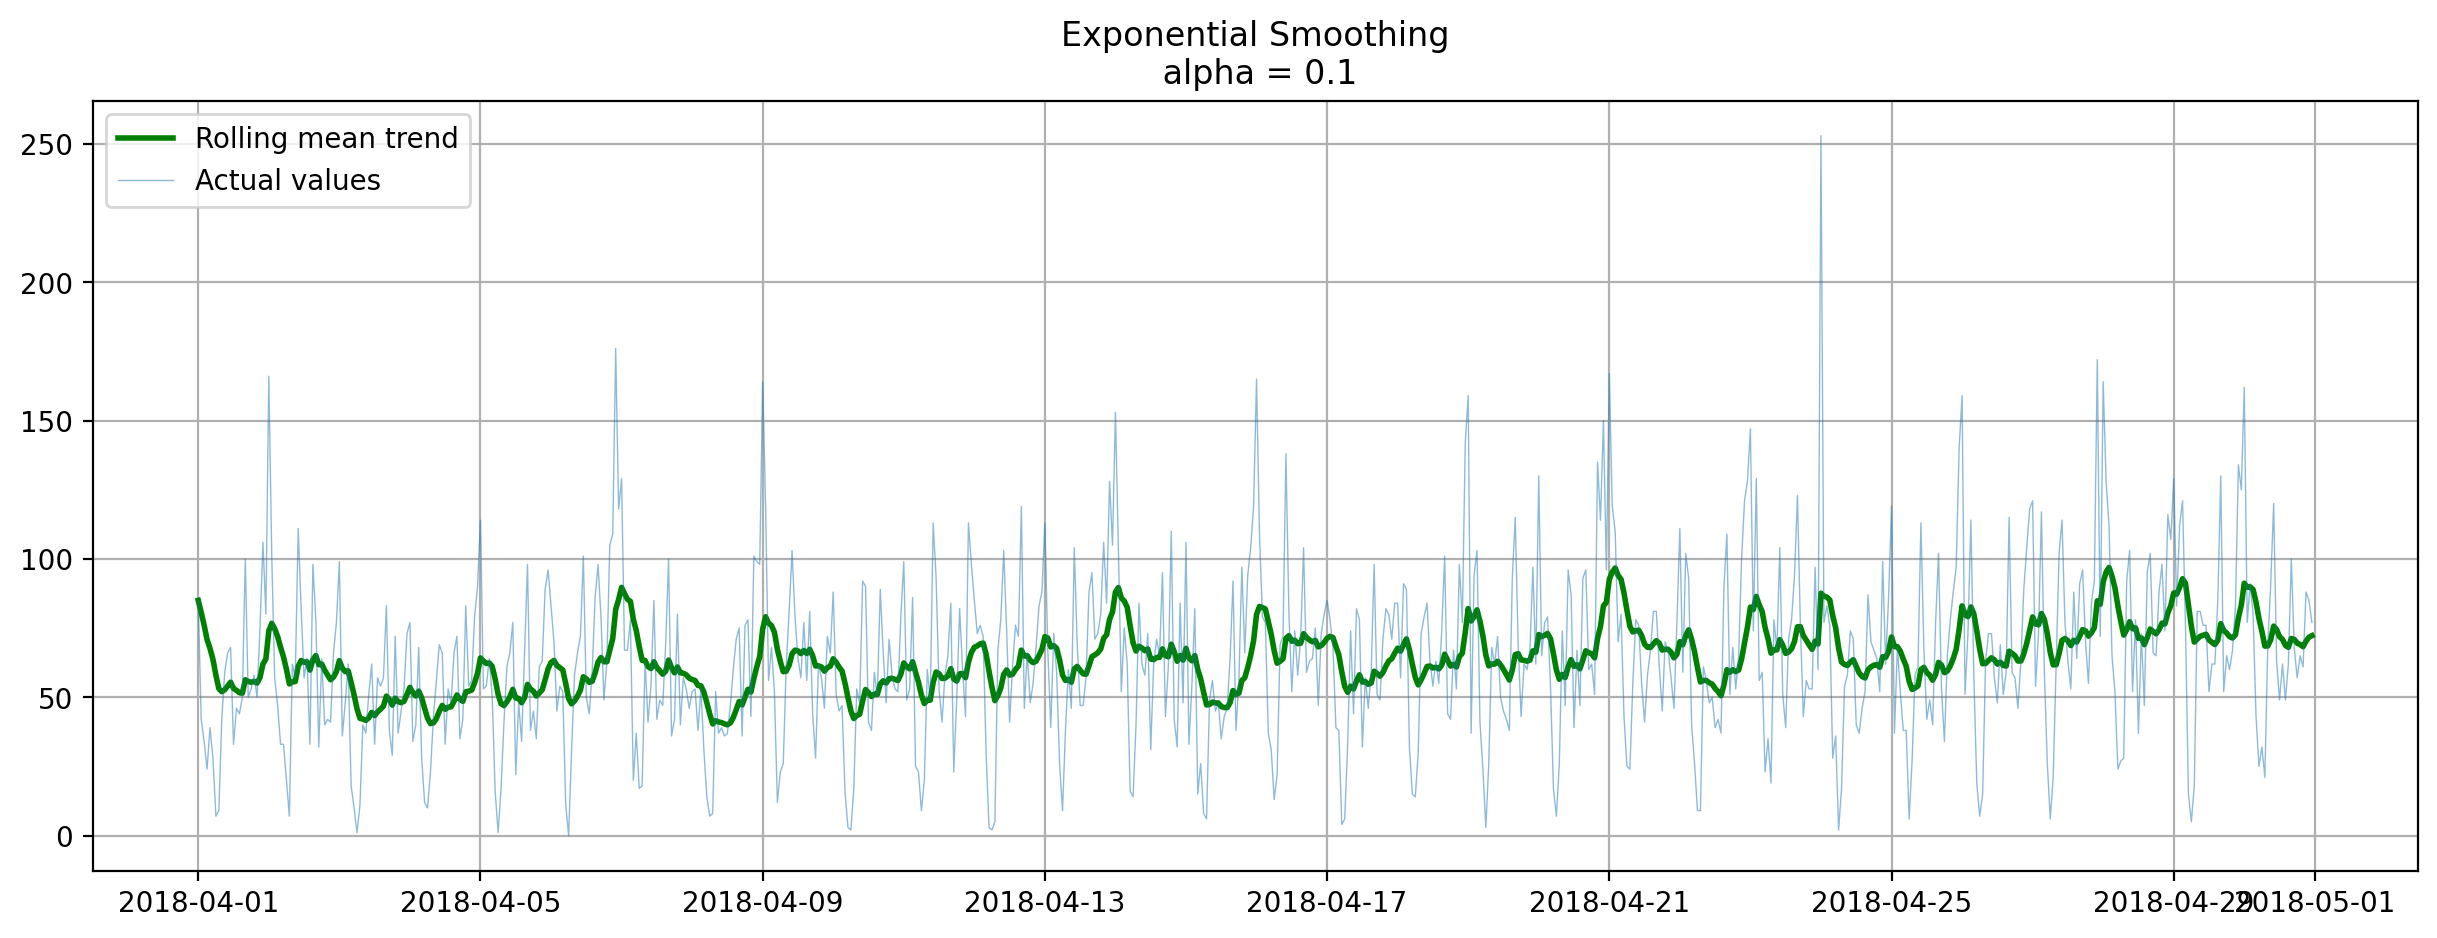

In [22]:
plotExpSmoothing(
    data["2018-04-01":"2018-04-30"], .1, plot_intervals=False, plot_anomalies=False
)

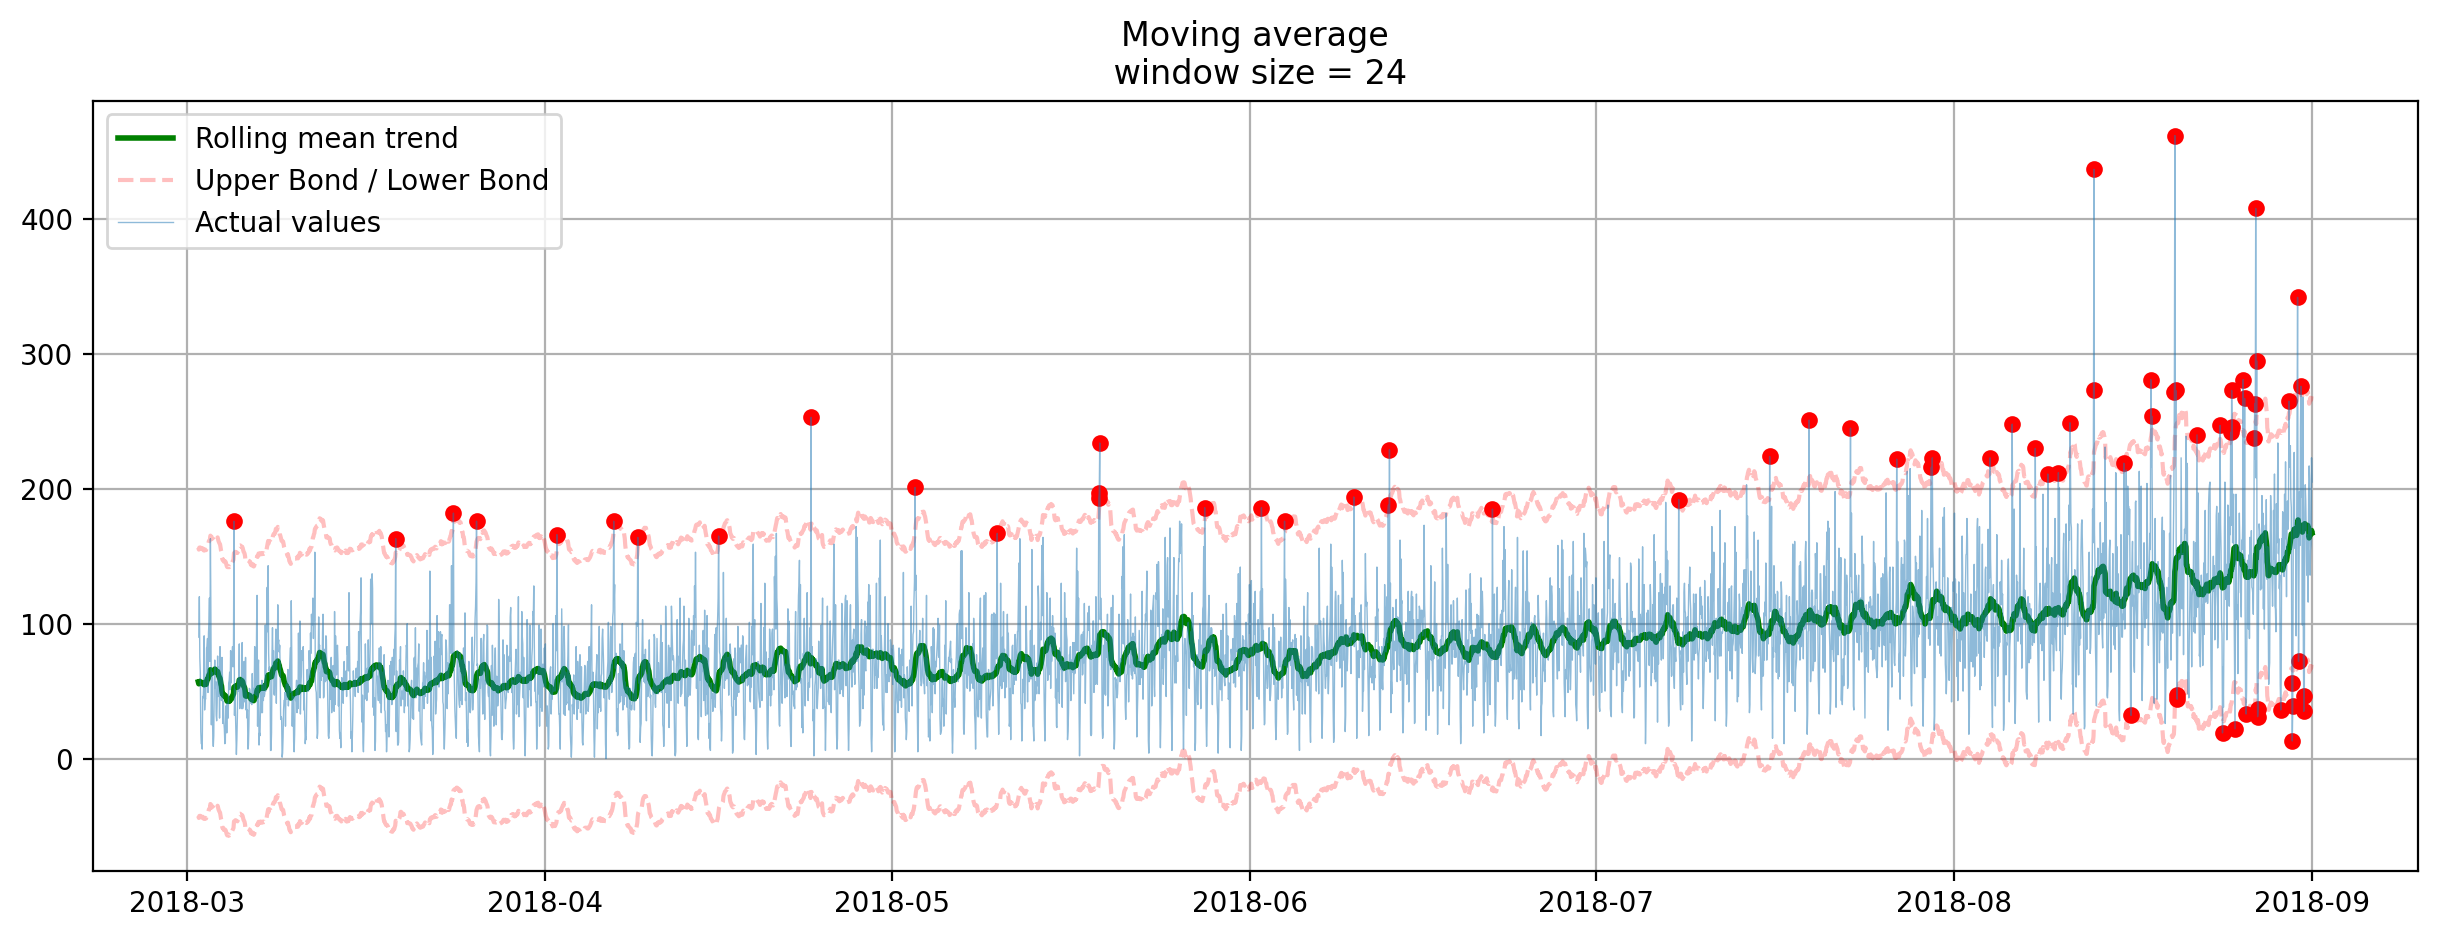

In [23]:
plotMovingAverage(
    data, 24, plot_intervals=True, plot_anomalies=True
)  # daily smoothing

## Подготовка данных

## Обучение моделей

## Тестирование

## Вывод